# Scalability

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
import pandas as pd

TOTAL_RAM = "2g" 
MODEL_NAME = "Scalability"

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 12:45:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Speed Up

In [ ]:
num_cores = [1, 2, 3, 4]

# for i in range(10):
for cores in num_cores:
    print(f'Analysing with {cores} ')
    !python code/scalability_local.py {cores} 100 speedup.csv


Analysing with 1 

--- STARTING: DecisionTree_cores1_pct100 ---

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 11:54:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
1. Loading Data...
   Features (19): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP']... (showing first 5)
   Assembling features...
   Training Rows: 9,666,878                                                     
   Partitions: 1

2. Training DecisionTree_cores1_pct100...
   Training completed in 78.28 seconds.                                         

3. Saving Model...
                                                                                
4. Evaluating on Validation Set...
   Validation RMSE: 7.5483                                                      

SU

In [13]:
def speed_up(results, runtime_col):
    return results[runtime_col].iloc[0] / results[runtime_col]

In [ ]:
results = pd.read_csv('scalability_results/speedup.csv', 
                      names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2'])

grouped = results.groupby('cores')
avg_results = grouped.mean()
std = grouped.std()
avg_results['speed-up'] = speed_up(avg_results, 'total_runtime')

avg_results


,pct,total_runtime,train_count,accuracy,speed-up
cores,,,,,
1,100.0,81.144026,9666878.0,7.548312,1.000000
2,100.0,53.942701,9666878.0,7.741243,1.504263
4,100.0,39.889644,9666878.0,7.463167,2.034213
8,100.0,43.756090,9666878.0,7.398182,1.854462
12,100.0,44.710899,9666878.0,7.442215,1.814860


In [21]:
from matplotlib import pyplot as plt

def plot_scalability_measure(name, stats, xlabel, x_vals, linear_vals):
    # Create the plot with single subplot
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.suptitle(
        f"{name.capitalize()} of a PySpark ML model with Decision Trees"
    )
    
    # Plot the measure
    ax.plot(x_vals, stats[name], "ko-", label=f"Real {name}")
    
    # Plot the linear values for the measure
    ax.plot(x_vals, linear_vals, "--", color="gray",
            label=f"Linear {name}", linewidth=1)
    
    ax.set(xlabel=xlabel, ylabel=name.capitalize())
    
    if name == "scale-up":
        ax.set_ylim([0, 1.1])
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()

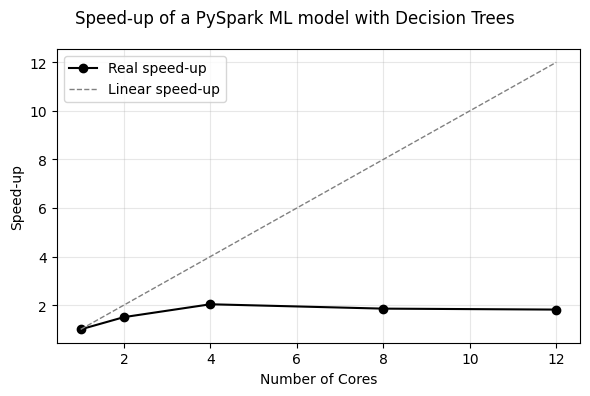

In [22]:
x_vals = avg_results.index.values
linear_vals = x_vals  # Linear speedup
plot_scalability_measure('speed-up', avg_results, 'Number of Cores', x_vals, linear_vals)
plt.show()

## Size Up

Options to do the division:
- Load all data and sample by percentage:
```python
# Load the full universe
df_full = spark.read.parquet("path/to/noaa_data/year=*.parquet")

# Create your 20% slice
df_20 = df_full.sample(withReplacement=False, fraction=0.2, seed=42)
```

In [ ]:
sizes = [10, 25, 50, 75] 

#for i in range(10):
for fraction in sizes:
    !python code/scalability_global.py 4 {fraction} sizeup.csv  


--- STARTING: DecisionTree_cores4_pct10 ---

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 12:54:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
1. Loading Data...
   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP']... (showing first 5)
   Sampling 10% of total universe...
   Assembling features...
   Training Rows: 6,066,609                                                     
   Partitions: 4=====================================>              (6 + 2) / 8]

2. Training DecisionTree_cores4_pct10...
   Training completed in 58.27 seconds.                                         

4. Evaluating on Validation Set...
   Validation RMSE: 0.1002                                                      
   Validation R2: 0.98

In [ ]:
def size_up(results, runtime_col):
    return results[runtime_col] / results[runtime_col].iloc[0]

In [ ]:
results = pd.read_csv('scalability_results/sizeup.csv', 
                      names=['cores', 'pct', 'total_runtime', 'train_count', 'rmse', 'r2'])

grouped = results.groupby('cores')
avg_results = grouped.mean()
std = grouped.std()
avg_results['size-up'] = size_up(avg_results, 'total_runtime')

avg_results


In [ ]:
x_vals = avg_results.index.values
linear_vals = x_vals  # Linear sizeup
plot_scalability_measure('size-up', avg_results, 'Percentage of data', x_vals, linear_vals)
plt.show()

## Scale Up

The options with 4 cores and the 100% of data have already been tested and got it speedup and sizeup, so we wont rerun those

| Cores \ Size | 25         | 50         | 75         | 100        |
|--------------|------------|------------|------------|------------|
| 1            | ❌ New     | ❌ New     | ❌ New     | ✅ Speedup |
| 2            | ❌ New     | ❌ New     | ❌ New     | ✅ Speedup |
| 3            | ❌ New     | ❌ New     | ❌ New     | ✅ Speedup |
| 4            | ✅ Sizeup  | ✅ Sizeup  | ✅ Sizeup  | ✅ Both    |


In [ ]:
num_cores = [1, 2, 3]
sizes = [25, 50, 75]

In [ ]:
# for i in range(10):
for j in range(len(num_cores)):
    for k in range(len(sizes)):
        !python code/scalability_global.py {num_cores[j]} \
                                {sizes[k]} scaleup.csv

In [ ]:
def scale_up(results, runtime_col):
    return results[runtime_col].iloc[0] / results[runtime_col]

In [ ]:
# Load all three datasets
speedup = pd.read_csv(
    'scalability_results/speedup.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'accuracy']
)
speedup['size'] = 100  # ensure size column exists

sizeup = pd.read_csv(
    'scalability_results/sizeup.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'accuracy']
)
sizeup['cores'] = 4  # ensure cores column exists

scaleup_new = pd.read_csv(
    'scalability_results/scaleup.csv', 
    names=['cores', 'pct', 'total_runtime', 'train_count', 'accuracy']
)

# Combine all data
all_results = pd.concat([speedup, sizeup, scaleup_new], ignore_index=True)

grouped = results.groupby(['cores','pct'])
avg_results = grouped.mean()
std = grouped.std()
avg_results['scale-up'] = scale_up(avg_results, 'total_runtime')

avg_results


In [ ]:
ideal_scaleup = [1] * 5
plot_scalability_measure('scale-up', avg_results, 'Number of cores',
                         num_cores, ideal_scaleup)